# OpenAI Assistants API
The new Assistants API is a stateful evolution of Chat Completions API meant to simplify the creation of assistant-like experiences, and enable developer access to powerful tools like Code Interpreter and Retrieval.

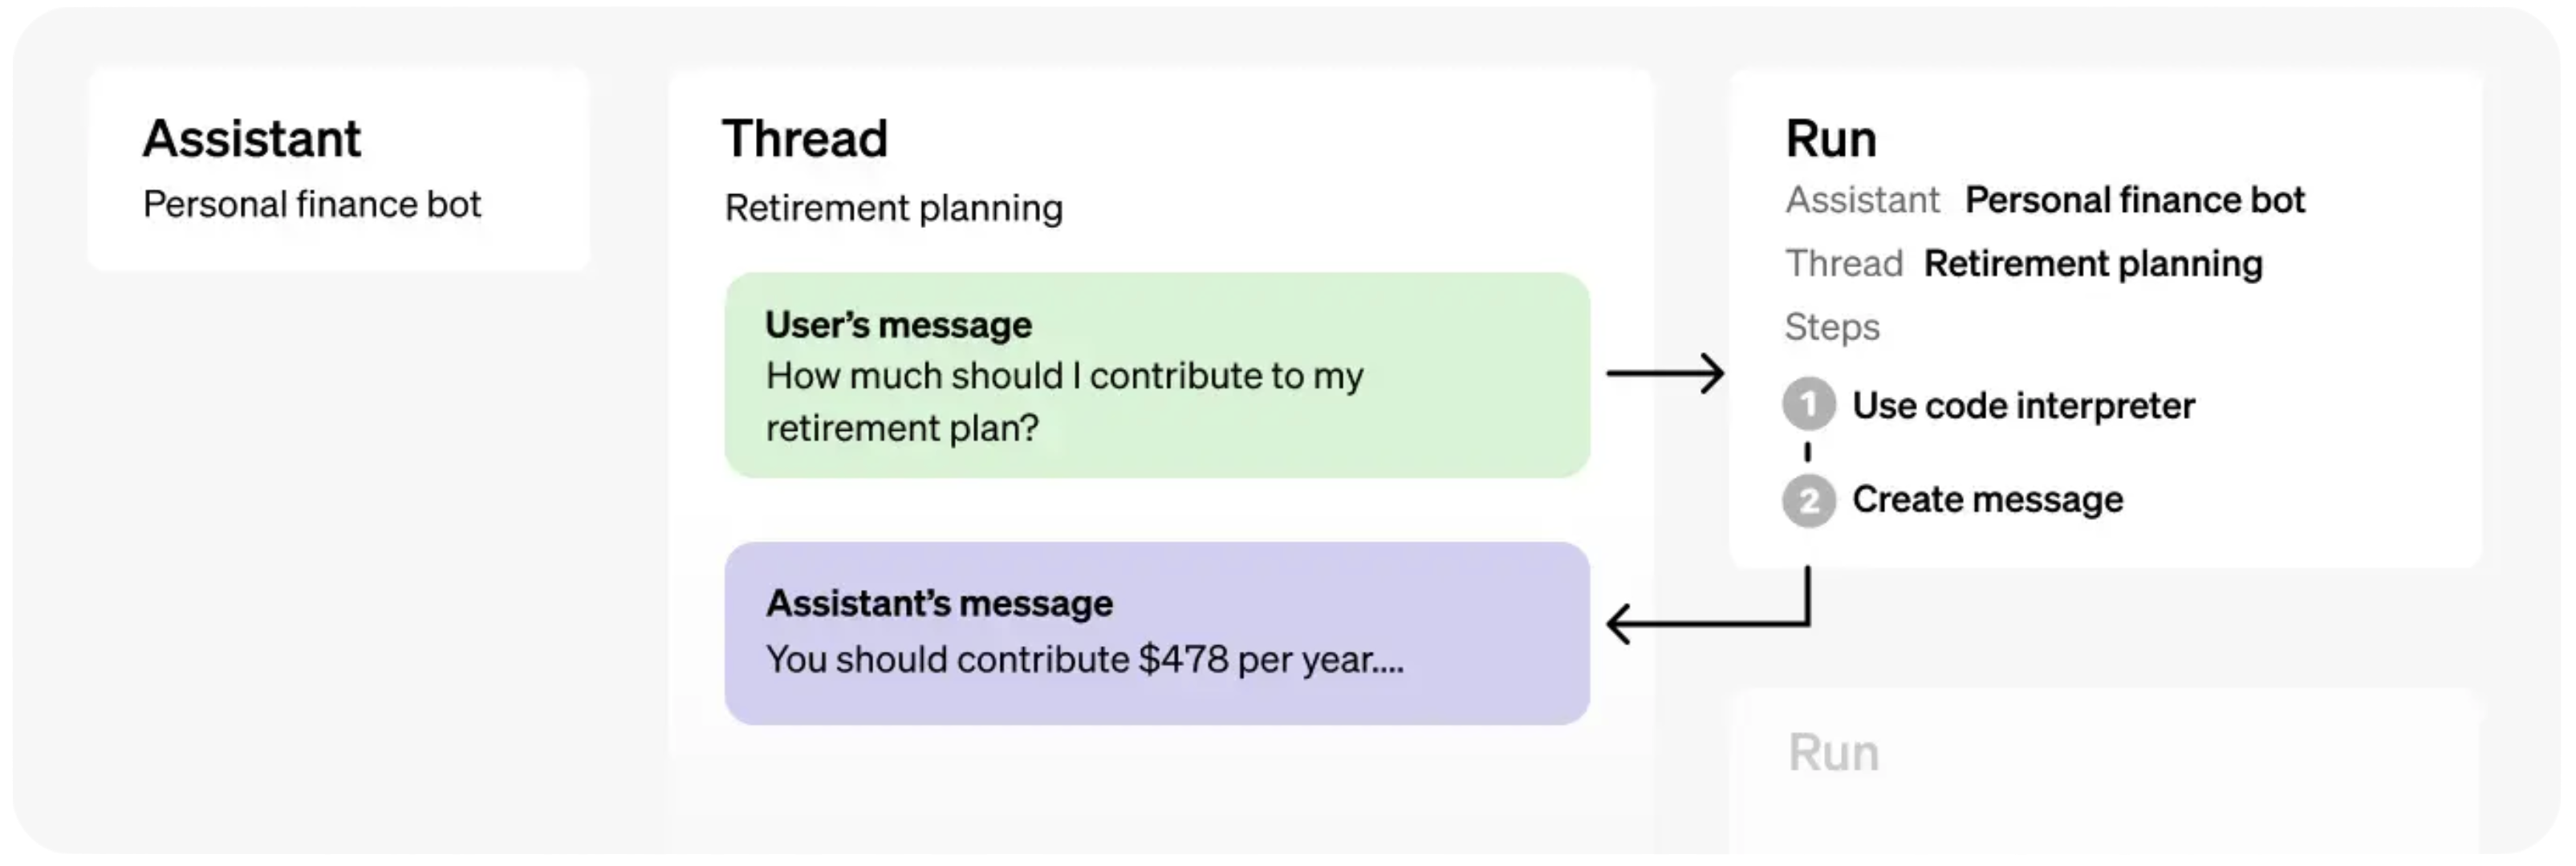

# Chat Completions API vs Assistants API
The primitives of the Chat Completions API are Messages, on which you perform a Completion with a Model (gpt-3.5-turbo, gpt-4, etc). It is lightweight and powerful, but inherently stateless, which means you have to manage conversation state, tool definitions, retrieval documents, and code execution manually.

The primitives of the Assistants API are

* Assistants, which encapsulate a base model, instructions, tools, and (context) documents,
* Threads, which represent the state of a conversation, and
* Runs, which power the execution of an Assistant on a Thread, including textual responses and multi-step tool use.

We'll take a look at how these can be used to create powerful, stateful experiences.

# Assistants API - Code Interpreter

https://cookbook.openai.com/examples/assistants_api_overview_python

https://platform.openai.com/docs/assistants/overview

Watch:

https://www.youtube.com/watch?v=5rcjGjgJNQc

In [1]:
from openai import OpenAI
import json
from dotenv import load_dotenv, find_dotenv

_ : bool = load_dotenv(find_dotenv())   # read local .env file

In [2]:
client: OpenAI = OpenAI()

# Code Interpreter

Code Interpreter allows the Assistants API to write and run Python code in a sandboxed execution environment. This tool can process files with diverse data and formatting, and generate files with data and images of graphs. Code Interpreter allows your Assistant to run code iteratively to solve challenging code and math problems. When your Assistant writes code that fails to run, it can iterate on this code by attempting to run different code until the code execution succeeds.

https://platform.openai.com/docs/assistants/tools/code-interpreter



# Step 1: Create an Assistant

In [3]:
from openai.types.beta import Assistant

assistant: Assistant = client.beta.assistants.create(
    name="Math Tutor",
    instructions="You are a personal Math Tutor. Write and run code to answer the math questions.",
    tools=[{"type":"code_interpreter"}],
    model="gpt-3.5-turbo-1106"
)

In [7]:
import json

def show_json(obj):
    display(json.loads(obj.model_dump_json()))

In [12]:
show_json(assistant)

{'id': 'asst_tB6d4LPCeIiaFnd8S5aAt6s2',
 'created_at': 1701537726,
 'description': None,
 'file_ids': [],
 'instructions': 'You are a personal Math Tutor. Write and run code to answer the math questions.',
 'metadata': {},
 'model': 'gpt-3.5-turbo-1106',
 'name': 'Math Tutor',
 'object': 'assistant',
 'tools': [{'type': 'code_interpreter'}]}

# Step 2: Create a Thread

In [13]:
from openai.types.beta.thread import Thread
thread: Thread = client.beta.threads.create()

# Step 3: Add a Message to a Thread

In [16]:
from openai.types.beta.threads.thread_message import ThreadMessage

message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content="I need to solve the equation '3x + 11 = 14'.Can you help me?"
)

In [17]:
show_json(message)

{'id': 'msg_6zEV04eILbwsbx1mw9Ph9Giy',
 'assistant_id': None,
 'content': [{'text': {'annotations': [],
    'value': "I need to solve the equation '3x + 11 = 14'.Can you help me?"},
   'type': 'text'}],
 'created_at': 1701538625,
 'file_ids': [],
 'metadata': {},
 'object': 'thread.message',
 'role': 'user',
 'run_id': None,
 'thread_id': 'thread_w4xzAwCRxsHzIVoohiOfQhep'}

# Step 4: Run the Assistant

In [18]:
from openai.types.beta.threads.run import Run

run: Run = client.beta.threads.runs.create(
    thread_id=thread.id,
    assistant_id=assistant.id,
    instructions="Please address the user as Jane Doe. The user has a premium account."
)

In [19]:
show_json(run)

{'id': 'run_jUg0Nh5A0waHgR6SQSBrw9qm',
 'assistant_id': 'asst_tB6d4LPCeIiaFnd8S5aAt6s2',
 'cancelled_at': None,
 'completed_at': None,
 'created_at': 1701539123,
 'expires_at': 1701539723,
 'failed_at': None,
 'file_ids': [],
 'instructions': 'Please address the user as Jane Doe. The user has a premium account.',
 'last_error': None,
 'metadata': {},
 'model': 'gpt-3.5-turbo-1106',
 'object': 'thread.run',
 'required_action': None,
 'started_at': None,
 'status': 'queued',
 'thread_id': 'thread_w4xzAwCRxsHzIVoohiOfQhep',
 'tools': [{'type': 'code_interpreter'}]}

# Step 5: Check the Run status

In [21]:
run: Run = client.beta.threads.runs.retrieve(
    thread_id=thread.id,
    run_id=run.id
)

In [22]:
show_json(run)

{'id': 'run_jUg0Nh5A0waHgR6SQSBrw9qm',
 'assistant_id': 'asst_tB6d4LPCeIiaFnd8S5aAt6s2',
 'cancelled_at': None,
 'completed_at': 1701539128,
 'created_at': 1701539123,
 'expires_at': None,
 'failed_at': None,
 'file_ids': [],
 'instructions': 'Please address the user as Jane Doe. The user has a premium account.',
 'last_error': None,
 'metadata': {},
 'model': 'gpt-3.5-turbo-1106',
 'object': 'thread.run',
 'required_action': None,
 'started_at': 1701539123,
 'status': 'completed',
 'thread_id': 'thread_w4xzAwCRxsHzIVoohiOfQhep',
 'tools': [{'type': 'code_interpreter'}]}

# Step 6: Display the Assistant's Response

In [23]:
# from openai.resources.beta.threads.messages.messages import SyncCursorPage 

messages: list[ThreadMessage] = client.beta.threads.messages.list(
    thread_id=thread.id
)

for m in reversed(messages.data):
    print(m.role + ": " + m.content[0].text.value)

user: I need to solve the equation '3x + 11 = 14'.Can you help me?
assistant: The solution to the equation 3x + 11 = 14 is x = 1.
